# Gold Project - Random Forest
Group Member: Enzo Goncalves Pereira

In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import ta

In [63]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'INTC', 'AMD']
all_data = []

df.head()

Price,Date,Close,High,Low,Open,Volume,Ticker,Return,MA5,MA10,Volatility,Volume_Change,RSI,MACD,MACD_Signal,BB_High,BB_Low,Target
Ticker,,AMD,AMD,AMD,AMD,AMD,,,,,,,,,,,,
33,2018-02-20,12.02,12.19,11.71,11.72,47096500,AMD,0.016921,12.002,11.747,0.198293,-0.004982,49.930813,-0.039506,-0.016738,13.694580,10.873420,11.72
34,2018-02-21,11.72,12.12,11.72,12.12,40195800,AMD,-0.024958,11.990,11.754,0.216102,-0.146523,46.206827,-0.058130,-0.025016,13.620284,10.825716,11.84
35,2018-02-22,11.84,12.00,11.63,11.82,37886300,AMD,0.010239,11.918,11.778,0.186601,-0.057456,47.881295,-0.062487,-0.032510,13.567570,10.791430,12.07
36,2018-02-23,12.07,12.16,11.94,11.95,33317600,AMD,0.019426,11.894,11.863,0.146219,-0.120590,51.027813,-0.046840,-0.035376,13.547186,10.777814,12.42
37,2018-02-26,12.42,12.43,12.05,12.14,42265200,AMD,0.028998,12.014,11.974,0.266796,0.268555,55.436803,-0.006128,-0.029527,13.479047,10.792953,12.53


In [64]:
for ticker in tickers:
    df = yf.download(ticker, start='2018-01-01', end='2023-12-31')
    df['Ticker'] = ticker
    df = df.reset_index()

    df['Return'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['Volatility'] = df['Close'].rolling(window=5).std()
    df['Volume_Change'] = df['Volume'].pct_change()

    close_series = df['Close'].squeeze()
    df['RSI'] = ta.momentum.RSIIndicator(close=close_series).rsi()
    macd = ta.trend.MACD(close=close_series)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    boll = ta.volatility.BollingerBands(close=close_series)
    df['BB_High'] = boll.bollinger_hband()
    df['BB_Low'] = boll.bollinger_lband()

    df['Target'] = df['Close'].shift(-1)

    df = df.dropna()
    all_data.append(df)

data = pd.concat(all_data, ignore_index=True)

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Ticker,Return,MA5,MA10,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,INTC,INTC,INTC,INTC,INTC,AMD,AMD,AMD,AMD,AMD
0,2018-02-20,40.548141,41.116780,40.446681,40.595331,135722000.0,AAPL,-0.003364,40.063495,38.787479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-21,40.364090,41.083737,40.349930,40.779362,149886400.0,AAPL,-0.004539,40.381084,38.992802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-02-22,40.701511,41.043639,40.515112,40.536347,123967600.0,AAPL,0.008359,40.623171,39.313880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-23,41.409359,41.444750,40.946894,40.977569,135249600.0,AAPL,0.017391,40.741619,39.808904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-02-26,42.228100,42.327199,41.576877,41.609910,152648800.0,AAPL,0.019772,41.050240,40.341209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# We select the features and the target
features = ['Close', 'MA5', 'MA10', 'Volatility', 'Volume_Change', 'RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']
X = data[features]
y = data['Target']

In [56]:
# I split my training and test, so I will train my model on 2018-2022 and test on 2023
train_data = data[data['Date'] < '2023-01-01']
test_data = data[data['Date'] >= '2023-01-01']

X_train = train_data[features]
y_train = train_data['Target']
X_test = test_data[features]
y_test = test_data['Target']

In [69]:
param_dist = {
    'n_estimators': [50],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=4,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_


Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [70]:
# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Best params:", random_search.best_params_)
print("Evaluation on 2023 data:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"mAPE: {mape:.2%}")

Best params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Evaluation on 2023 data:
RMSE: 6.07
R² Score: 1.00
mAPE: 2.37%


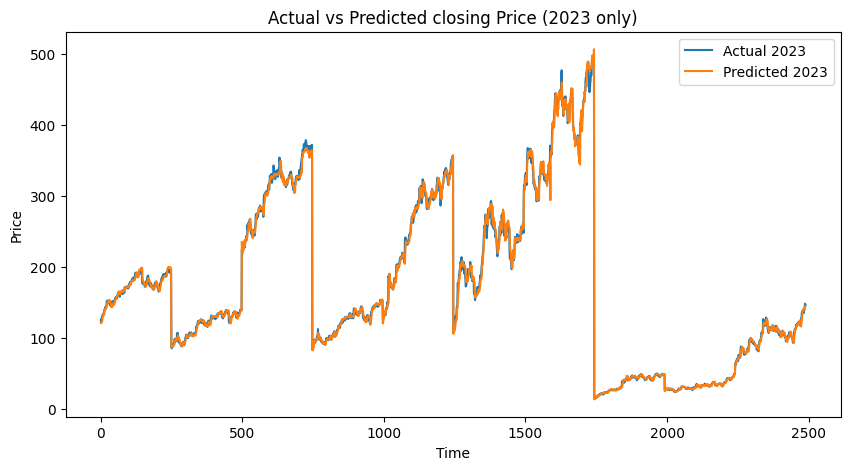

In [71]:
# Plot predicted vs actual
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual 2023')
plt.plot(y_pred, label='Predicted 2023')
plt.legend()
plt.title("Actual vs Predicted closing Price (2023 only)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


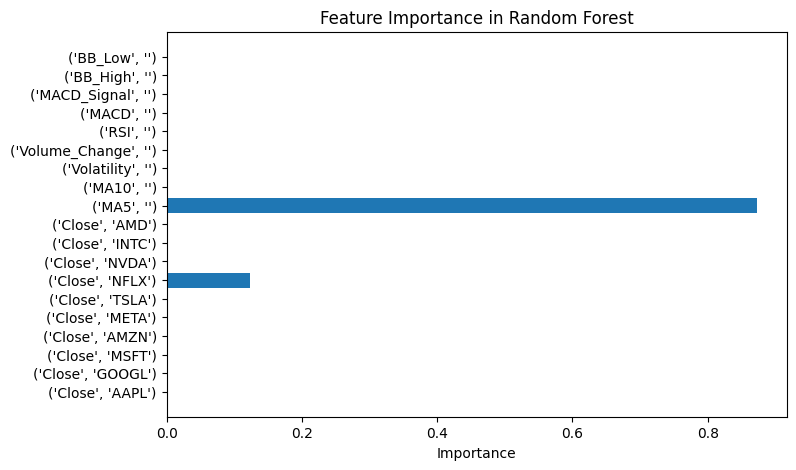

In [72]:
# Feature Importance
importances = best_model.feature_importances_
feature_names = [str(col) for col in X.columns]

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()